In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Figures", "Raw_traces", 'GENEActiv')
# load data
demogra_data = pd.read_csv("Demographics_data.csv")
task_score = pd.read_csv("Task_scores_part_I.csv")

In [3]:
task_score

,ROW_ID,ROW_VERSION,subject_id,visit,session,task_id,task_code,repetition,timestamp_start,timestamp_end,phenotype,body_segment,score
0,1,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,tremor,RightUpperLimb,0
1,2,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,tremor,LeftUpperLimb,0
2,3,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,tremor,LowerLimbs,0
3,4,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,dyskinesia,RightUpperLimb,Yes
4,5,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,dyskinesia,LeftUpperLimb,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62194,62195,22,12_NYC,2,8,260,sittg,1,1435327148,1435327182,dyskinesia,LeftUpperLimb,No
62195,62196,22,12_NYC,2,8,260,sittg,1,1435327148,1435327182,dyskinesia,LowerLimbs,No
62196,62197,22,12_NYC,2,8,260,sittg,1,1435327148,1435327182,bradykinesia,RightUpperLimb,No
62197,62198,22,12_NYC,2,8,260,sittg,1,1435327148,1435327182,bradykinesia,LeftUpperLimb,No


In [ ]:
# example session
device = 'GENEActiv'
subject_id = '4_NYC'
visit= 1
task_code = 'ramr'
session = 3
body_segment = 'RightUpperLimb'
phenotype = 'tremor'
most_affected_side = demogra_data['pd_most_affected_side'].loc[demogra_data.subject_id == subject_id]
is_trial = (task_score.subject_id == subject_id) & (task_score.visit == visit) &\
(task_score.task_code == task_code) & (task_score.session == session) &\
(task_score.phenotype == phenotype) & (task_score.body_segment == body_segment)
trial_idx = [i for i, val in enumerate(is_trial) if val][0]                    
score = task_score['score'].values[trial_idx]
ts_start = task_score['timestamp_start'].values[trial_idx]
ts_end = task_score['timestamp_end'].values[trial_idx]

# find sensor data
sensor_path = os.path.join(direc, device, subject_id, 'rawdata_day'+str(visit)+'.txt')
df = pd.read_table(sensor_path)

In [ ]:
is_ts = (df.timestamp.values >= ts_start) & (df.timestamp.values <= ts_end)
x = df['GENEActiv_X'].loc[is_ts].values
y = df['GENEActiv_Y'].loc[is_ts].values
z = df['GENEActiv_Z'].loc[is_ts].values
dt = round(df.timestamp[1] - df.timestamp[0],2)
t= range(len(x))*dt

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(t,x,'-b',t,y,'-g',t,z,'-r')
# # save figure
# plt.savefig(os.path.join(save_path,"6_BOS_RUL"))

In [ ]:
# Load score data
score_file_path = os.path.join(direc, 'Feature_extraction','score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

In [ ]:
df_score.head(20)

In [ ]:
# # Try different task categories
# # task categories
# task_groups = [['stndg', 'sittg', 'wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd',
#               'ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng'],
#                ['stndg', 'sittg'],['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd'],
#                ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']]
# task_group_names = ['all', 'no_voluntary_movement','lowerlimb_movement', 'upperlimb_movement']

In [ ]:
# task = ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']
task = ['ramr']
is_tasks = df_score['task_code'].isin(task).tolist()
df_score_task = df_score[is_tasks]

In [ ]:
df_score_task[df_score_task['subject_id']=='4_NYC']

In [ ]:
df_score_task[df_score_task['bradykinesia_GENEActivHand']=='No'].head(30)

In [4]:
# example session
device = 'GENEActiv'
subject_id = '4_NYC'
geneactive_hand = demogra_data['geneactive_hand'].loc[demogra_data.subject_id == subject_id].values[0]
visit= 1
task_code = 'ramr'
session = 3
body_segment = geneactive_hand + 'UpperLimb'
phenotype = 'bradykinesia'
is_trial = (task_score.subject_id == subject_id) & (task_score.visit == visit) &\
(task_score.task_code == task_code) & (task_score.session == session) &\
(task_score.phenotype == phenotype) & (task_score.body_segment == body_segment)
trial_idx = [i for i, val in enumerate(is_trial) if val][0]                    
score = task_score['score'].values[trial_idx]
ts_start = task_score['timestamp_start'].values[trial_idx]
ts_end = task_score['timestamp_end'].values[trial_idx]

# find sensor data
sensor_path = os.path.join(direc, device, subject_id, 'rawdata_day'+str(visit)+'.txt')
df = pd.read_table(sensor_path)

In [5]:
score

'Yes'

In [7]:
is_ts = (df.timestamp.values >= ts_start) & (df.timestamp.values <= ts_end)
x = df['GENEActiv_X'].loc[is_ts].values
y = df['GENEActiv_Y'].loc[is_ts].values
z = df['GENEActiv_Z'].loc[is_ts].values
dt = round(df.timestamp[1] - df.timestamp[0],2)
t= range(len(x))*dt

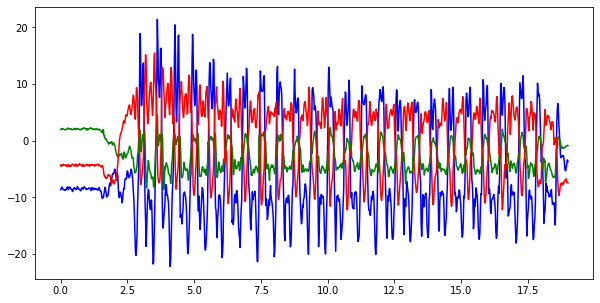

In [8]:
fig = plt.figure(figsize=(10,5))
plt.plot(t,x,'-b',t,y,'-g',t,z,'-r')
# save figure
file_name = subject_id + '_visit_' + str(visit) + '_session_' + str(session) + '_' + task_code
plt.savefig(os.path.join(save_path,file_name))